# Simple IMPT plan optimization

In [12]:
import math
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import IMPTPlanOptimizer

## CT calibration and BDL

In [13]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

## Create synthetic CT and ROI

In [14]:
patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

## Configure dose engine

In [15]:
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

mc2._independentScoringGrid = True
scoringSpacing = [2, 2, 2]
mc2._scoringVoxelSpacing = scoringSpacing

## Design plan

In [16]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

planInit = PlanDesign()
planInit.ct = ct
planInit.gantryAngles = gantryAngles
planInit.beamNames = beamNames
planInit.couchAngles = couchAngles
planInit.calibration = ctCalibration
planInit.spotSpacing = 6.0
planInit.layerSpacing = 6.0
planInit.targetMargin = 0.0
planInit.setScoringParameters(scoringSpacing=[2, 2, 2], adapt_gridSize_to_new_spacing=True)
# needs to be called after scoringGrid settings but prior to spot placement
planInit.defineTargetMaskAndPrescription(target = roi, targetPrescription = 20.) 
        
plan = planInit.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
plan.planDesign.beamlets = beamlets
# doseImageRef = beamlets.toDoseImage()

31/07/2024 03:30:38 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
31/07/2024 03:30:38 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 0.0 mm. This process might take some time.
31/07/2024 03:30:38 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
31/07/2024 03:30:40 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 1.5307490825653076 sec
31/07/2024 03:30:40 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 84
31/07/2024 03:30:40 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
31/07/2024 03:30:42 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
31/07/2024 03:30:42 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil

MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.338487 s 


Simulation of beamlet 84/84  
MC computation time: 2.214744 s 
Output computation time: 0.007743 s 

Simulation of beamlet 81/84  
MC computation time: 2.232245 s 
Output computation time: 0.006085 s 

Simulation of beamlet 80/84  
MC computation time: 2.238036 s 
Output computation time: 0.007071 s 

Simulation of beamlet 83/84  
MC computation time: 2.268629 s 
Output computation time: 0.007023 s 

Simulation of beamlet 72/84  
MC computation time: 2.286322 s 
Output computation time: 0.006486 s 

Simulation of beamlet 82/84  
MC computation time: 2.303428 s 
Output computation time: 0.006998 s 

Simulation of beamlet 75/84  
MC computation time: 2.307691 s 
Output computation time: 0.007606 s 

Simulation of beamlet 71/84  
MC computation time: 2.358912 s 
Output computation time: 0.006183 s 

Simulation of beamlet 73/84  
MC computation time: 2.367302 s 
Output computation time: 0.006670 s 

Simulation of beamlet 74/84  
MC computation time: 2.

## Objectives

In [17]:
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.5, 1.0)
# Other examples of objectives
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMEAN, 20, 1.0) 
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DUNIFORM, 20, 1.0)
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DVHMIN, 19, 1.0, volume = 95)
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DVHMAX, 21, 1.0, volume = 5)
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.EUDMIN, 19.5, 1.0, EUDa = 0.2)
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.EUDMAX, 20, 1.0, EUDa = 1)
# plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.EUDUNIFORM, 20.5, 1.0, EUDa = 0.5)
# plan.planDesign.objectives.addFidObjective(BODY, FidObjective.Metrics.DFALLOFF, weight=10, fallOffDistance=1, fallOffLowDoseLevel=0, fallOffHighDoseLevel=21)
    

## Optimize plan

In [18]:
solver = IMPTPlanOptimizer(method='Scipy_L-BFGS-B', plan=plan, maxiter=50)
doseImage, ps = solver.optimize()

31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...


[20.0]
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 1 of Scipy-L-BFGS-B
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 4.518506e+01  
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 2 of Scipy-L-BFGS-B
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 3.697231e+01  
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 3 of Scipy-L-BFGS-B
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 2.988740e+01  
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 4 of Scipy-L-BFGS-B
31/07/2024 03:30:48 PM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 2.375689e+01  
31/07/2024 03:30:48 PM - open

## Final dose computation

In [19]:
mc2.nbPrimaries = 1e7
doseImage = mc2.computeDose(ct, plan)

31/07/2024 03:30:48 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
31/07/2024 03:30:48 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd


31/07/2024 03:30:48 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
31/07/2024 03:30:49 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.391591 s 


Simulation started (2024-07-31 15:30:49) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 0.70 %) 
 60.0 % (stat uncertainty: 0.64 %) 
 70.0 % (stat uncertainty: 0.61 %) 
 80.0 % (stat uncertainty: 0.58 %) 
 90.0 % (stat uncertainty: 0.56 %) 
 100.0 % (stat uncertainty: 0.53 %) 

Nbr primaries simulated: 10000000 (99306 generated outside the geometry) 
MC computation time: 8.463978 s 
Output computation time: 0.001443 s 

Total computation time: 8.857024 s 


## Plots

D95 = 14.83154296875 Gy
D5 = 23.638916015625 Gy
D5 - D95 =  8.807373046875 Gy
31/07/2024 03:30:58 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


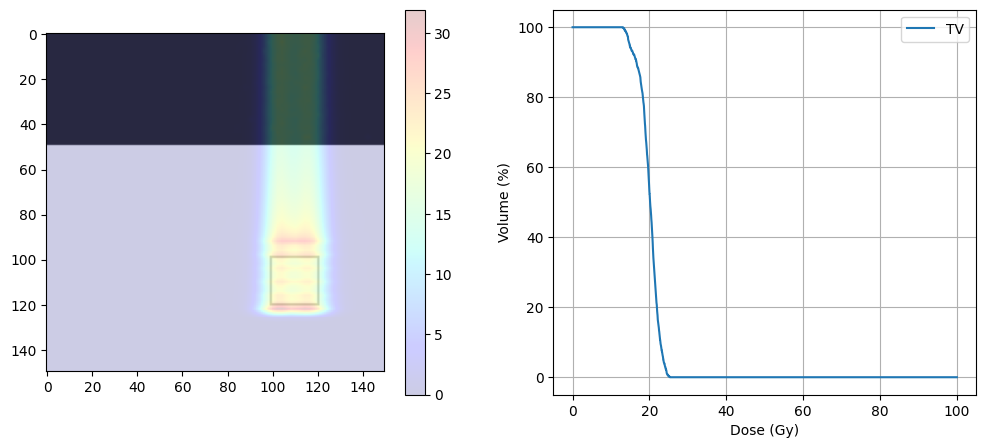

In [20]:
 # Compute DVH on resampled contour
roiResampled = resampleImage3D(roi, origin=ct.origin, spacing=scoringSpacing)
target_DVH = DVH(roiResampled, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

#Output path
output_path = 'Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()
plt.show()

plt.savefig(os.path.join(output_path, 'SimpleOpti1.png'),format = 'png')
plt.close()

![png](\assets\img_notebooks\SimpleOpti1.png)